In [92]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# for linear regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# recursive feature elimination (w/ cross validation), linear regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [93]:
# creates dictionary of variance inflation factors. 
def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y):

    linreg = LinearRegression()
    selector = RFE(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    return selections, rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict



In [2]:
data = pd.read_csv('data/base_model.csv')

Baseline model was fairly strong in the EDA notebook but the Jarque-Bera test was not in favor of normality.
- First plan of action is to eliminate outliers in the target variable and observe how this will affect the model. 

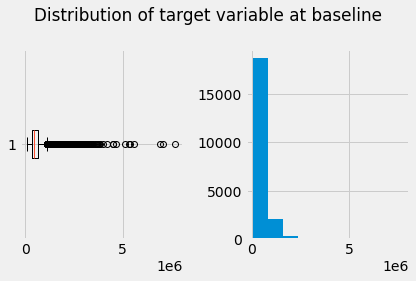

In [69]:
# target variable clearly shows an excessive volume of outliers
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(data.price,vert=False)
ax2.hist(data.price)

fig.suptitle("Distribution of target variable at baseline")
plt.tight_layout()
plt.show()

### Removing outliers:
- based on statistical max: to account for outliers and reflect the plot above statistical max is represented by inter quartile range multiplied by 1.5, in lieu of actual maximum value.
- based on standard deviation: removing any values more than 3 standard deviations from the mean
- arbitrary trim: removing the top 5% most extreme values

Defining thresholds to investigate

In [71]:
iqr = data.price.quantile(0.75) - data.price.quantile(0.25)
max_thresh = iqr*1.5 # statistical maximum 

std_thresh = data.price.std()*3 # three standard deviations

top_5_percentile = data.price.quantile(0.95) #95th percentile (top 5% highest values)

1160000.0

Stastical Maximum

In [41]:
max_cap = data['price'].loc[abs(data['price']) <= max_thresh] # keeping data only at or within the statistical maximum. 

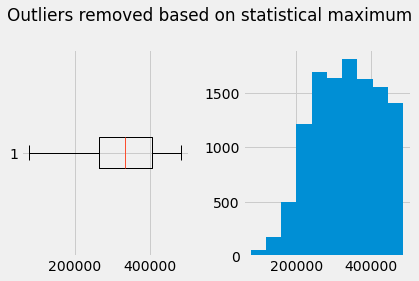

Percent of data retained:  0.5521
this box plot indicates the data will be better suited for the regression model, however it has dropped about half the data... 


In [86]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(max_cap,vert=False)
ax2.hist(max_cap)

fig.suptitle("Outliers removed based on statistical maximum")
plt.tight_layout()
plt.show()

print('Percent of data retained: ',round(len(max_cap)/len(data.price),4))  
print('this box plot indicates the data will be better suited for the regression model, however it has dropped about half the data... ')

3 standard deviations

In [44]:
std_cap = data['price'].loc[abs(data['price']) <= std_thresh]

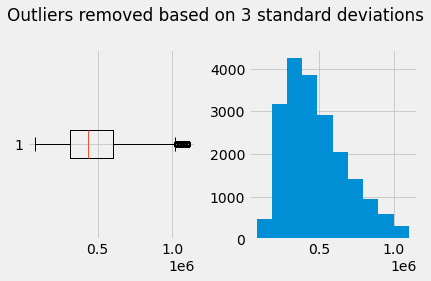

Percent of data retained:  0.9451
boxplot shows retention of some outliers, but the histogram is closer to normal than max_cap and retain most of the data (nearly all of it)


In [84]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(std_cap,vert=False)
ax2.hist(std_cap)

fig.suptitle("Outliers removed based on 3 standard deviations")
plt.tight_layout()
plt.show()

print('Percent of data retained: ',round(len(std_cap)/len(data.price),4))  
print('boxplot shows retention of some outliers, but the histogram is closer to normal than max_cap and retain most of the data (nearly all of it)')

In [72]:
top_5_cap = data['price'].loc[abs(data['price']) < top_5_percentile]

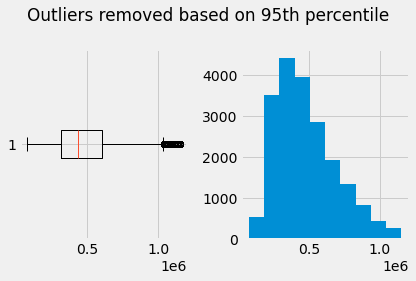

Percent of data retained:  0.9496
extremely similar results to elimination based on standard devation, retains slightly more data


In [83]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(top_5_cap,vert=False)
ax2.hist(top_5_cap)

fig.suptitle("Outliers removed based on 95th percentile")
plt.tight_layout()
plt.show()

print('Percent of data retained: ',round(len(top_5_cap)/len(data.price),4))  
print('extremely similar results to elimination based on standard devation, retains slightly more data')

#### Observations on elimination of outliers 

Elimination based on statistical maximum eliminated way too much data so it wan't be investigated further, full-stop. 
Elimination based on 95th percentile retained slightly more data than elmination based on 3 standard deviaitons... However both results round to 95% of the data retained; considering the whole goal is to actually *eliminate* outliers, not just some arbitrary slice of data, I will continue with the data with outliers eliminated based on 3 standard deviations because this is a statistical method and not an arbitrary slice. 

In [88]:
data = data.loc[abs(data.price) <= std_thresh] # slicing data to eliminate outliers using selected method